# Part-1 HMMs and Viterbi algorithm for POS tagging
***

__[Ankit Bhatia](https://www.linkedin.com/in/ab9bhatia/)__

## Prerequisite

Download all __NLTK__ modules using __nltk.download()__

## Import Libraries

In [1]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize

import seaborn as sns
import random

import gzip, os, pickle # gzip for reading the gz files, pickle to save/dump trained model 
import _pickle as cPickle

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

# train-test split
from sklearn.model_selection import train_test_split

import time

C:\Anaconda3_5.1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3_5.1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data Preprocessing

In [2]:
# reading the Treebank tagged sentences
data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print('Number of Sentences in the corpus::',len(data),'\n')
# print first two tagged sentences
print(data[0:2])

Number of Sentences in the corpus:: 3914 

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [4]:
# Splitting into train and test
train_set, test_set = train_test_split(data,test_size=0.05, random_state=27)

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print('Number of tagged words in the training set::',len(train_tagged_words))

Number of tagged words in the training set:: 95475


In [6]:
# Vocabulary 
tokens = [pair[0] for pair in train_tagged_words]
V = set(tokens)
print('Number of unique words::',len(V),'\n')
print(tokens[0:10])

Number of unique words:: 12042 

['Nissan', 'Motor', 'Co.', ',', 'Japan', "'s", 'second-largest', 'car', 'maker', ',']


In [7]:
# Number of Tags
T = set([pair[1] for pair in train_tagged_words])
print('Number of tags::',len(T),'\n')
print(T)

Number of tags:: 12 

{'PRT', 'ADJ', 'CONJ', 'NUM', '.', 'X', 'ADV', 'VERB', 'ADP', 'PRON', 'NOUN', 'DET'}


### POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [8]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [9]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [10]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [11]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

## Exploratory Data Analysis

In [12]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRT,ADJ,CONJ,NUM,.,X,ADV,VERB,ADP,PRON,NOUN,DET
PRT,0.001965,0.085789,0.001965,0.055992,0.043222,0.012443,0.009496,0.402423,0.020301,0.018009,0.246889,0.101506
ADJ,0.010772,0.066291,0.016573,0.020882,0.064965,0.021213,0.004475,0.012264,0.077395,0.000663,0.699867,0.004640
CONJ,0.005086,0.116967,0.000462,0.040222,0.036061,0.008784,0.054092,0.156264,0.054092,0.059177,0.349977,0.118816
NUM,0.026635,0.032850,0.013318,0.186150,0.116307,0.208642,0.001776,0.017757,0.035513,0.001480,0.356318,0.003255
.,0.002345,0.044192,0.058532,0.081710,0.092172,0.027507,0.052579,0.088654,0.091540,0.065206,0.221140,0.174333
X,0.185486,0.017225,0.010686,0.002711,0.161563,0.073844,0.025678,0.205582,0.144019,0.054864,0.063477,0.054864
ADV,0.014681,0.128128,0.006673,0.031698,0.136470,0.024024,0.078412,0.343677,0.118118,0.016016,0.033033,0.069069
VERB,0.031413,0.064847,0.005598,0.023326,0.034523,0.217790,0.082031,0.168261,0.091206,0.035767,0.110256,0.134982
ADP,0.001391,0.106012,0.000856,0.063222,0.039902,0.034446,0.013800,0.008344,0.017330,0.069106,0.322636,0.322957
PRON,0.012317,0.071594,0.004619,0.007313,0.041186,0.093918,0.034642,0.485758,0.021555,0.008083,0.209392,0.009623


In [13]:
tags_df.loc['.', :]

PRT     0.002345
ADJ     0.044192
CONJ    0.058532
NUM     0.081710
.       0.092172
X       0.027507
ADV     0.052579
VERB    0.088654
ADP     0.091540
PRON    0.065206
NOUN    0.221140
DET     0.174333
Name: ., dtype: float32

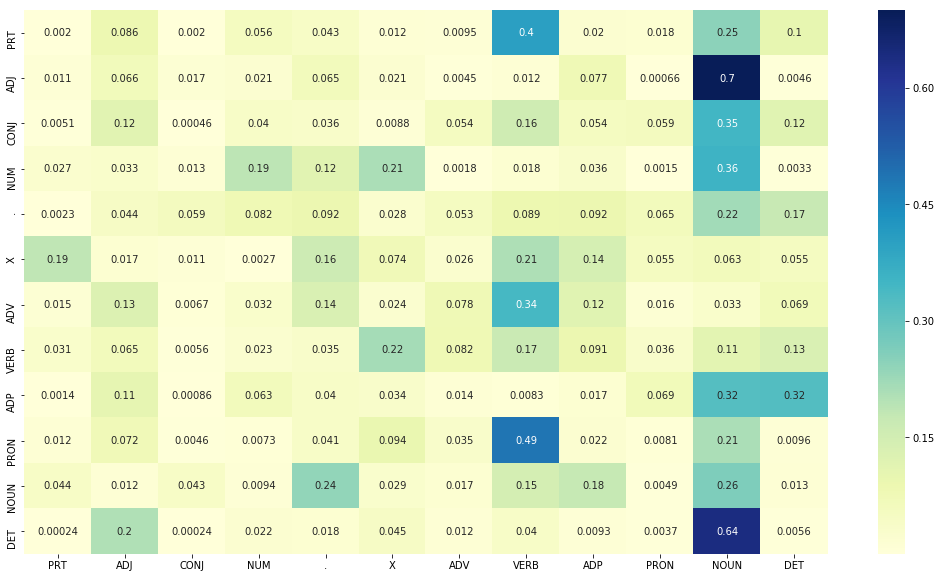

In [14]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 10))
sns.heatmap(tags_df, cmap="YlGnBu",annot=True)
plt.show()

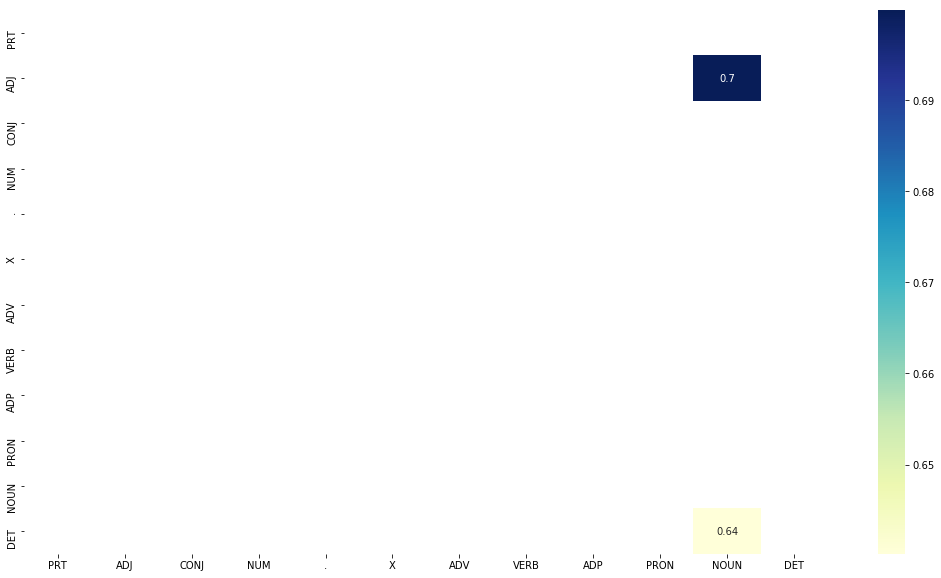

In [15]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 10))
sns.heatmap(tags_frequent, cmap="YlGnBu",annot=True)
plt.show()

## Build the vanilla Viterbi based POS tagger

### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

### Vanila Viterbi

In [16]:
def Viterbi(test_bag, train_bag = train_tagged_words):
    start = time.time()
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(test_bag):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(test_bag[key], tag)[0]/word_given_tag(test_bag[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        end = time.time()
        Execution_Time = end-start
    return list(zip(test_bag, state)),Execution_Time

### Test Data preparion
#### Running on entire test dataset would take more than 3-4hrs. 
#### So we will run Viterbi algorithm on 5 random sample sentences of test dataset

In [17]:
random.seed(27)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

### Define Evaluation function to get the Accuracy & Incorrect Tageed cases

In [18]:
def getEvaluation(tagged_seq,test_run_base):
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
    accuracy = len(check)/len(tagged_seq)
    incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
    count_incorrect_tagged_cases = len(incorrect_tagged_cases)
    return accuracy,incorrect_tagged_cases,count_incorrect_tagged_cases

### Create a Dataframe to save the Performance matrix.

In [19]:
model_summary = pd.DataFrame(columns=['Accuracy','Count Incorrect Tagged Cases','Execution Time'])

## Model Summary of Vanila Viterbi

In [20]:
# Execute Viterbi-Advance
tagged_seq,Execution_Time = Viterbi(test_bag = test_tagged_words)

# Performance Matrix
accuracy,incorrect_tagged_cases,count_incorrect_tagged_cases = getEvaluation(tagged_seq,test_run_base)

#Save in Dataframe
model_summary.loc['Viterbi Vanila'] = [accuracy,count_incorrect_tagged_cases,Execution_Time]

# Display Results
display(model_summary[model_summary.index=='Viterbi Vanila'])
print('\n','Incorrect Tagges Cases::')
incorrect_tagged_cases

,Accuracy,Count Incorrect Tagged Cases,Execution Time
Viterbi Vanila,0.886525,16.0,24.624727



 Incorrect Tagges Cases::


[[("'s", 'PRT'), (('firm', 'NOUN'), ('firm', 'ADJ'))],
 [('steady', 'ADJ'), (('opening', 'VERB'), ('opening', 'NOUN'))],
 [('also', 'ADV'), (('tempted', 'PRT'), ('tempted', 'VERB'))],
 [('and', 'CONJ'), (('potentially', 'PRT'), ('potentially', 'ADV'))],
 [('potentially', 'ADV'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('For', 'ADP'), (('starters', 'PRT'), ('starters', 'NOUN'))],
 [('H.', 'NOUN'), (('Hudnut', 'PRT'), ('Hudnut', 'NOUN'))],
 [('Indianapolis', 'NOUN'), (('Symphony', 'PRT'), ('Symphony', 'NOUN'))],
 [('Symphony', 'NOUN'), (('Orchestra', 'PRT'), ('Orchestra', 'NOUN'))],
 [('a', 'DET'), (('guest', 'PRT'), ('guest', 'NOUN'))],
 [('guest', 'NOUN'),
  (('pianist-comedian', 'PRT'), ('pianist-comedian', 'NOUN'))],
 [('pianist-comedian', 'NOUN'), (('Victor', 'PRT'), ('Victor', 'NOUN'))],
 [('Victor', 'NOUN'), (('Borge', 'PRT'), ('Borge', 'NOUN'))],
 [('from', 'ADP'), (('soured', 'PRT'), ('soured', 'ADJ'))],
 [('something', 'NOUN'), (('structurally', 'PRT'), ('structurally', 'ADV'))]

## Solve the Problem of Unknown Words :: Improve the performance 
The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily.
Let's modify the Viterbi Algorithm by including the methods that can resolve the issue of unknown words.

### 1. Unigram Tagging
Unigram taggers are based on a simple statistical algorithm: for each token, assign the tag that is most likely for that particular token. For example, it will assign the tag JJ to any occurrence of the word _frequent_, since _frequent_ is used as an adjective (e.g. a _frequent_ word) more often than it is used as a verb (e.g. I _frequent_ this cafe). A unigram tagger behaves just like a lookup tagger (4), except there is a more convenient technique for setting it up, called training. In the following code sample, we train a unigram tagger, use it to tag a sentence, then evaluate:

In [21]:
unigram_tagger = nltk.UnigramTagger(train_set)

### 2. N-Gram Tagging
An n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the part-of-speech tags of the n-1 preceding tokens.

In [22]:
bigram_tagger = nltk.BigramTagger(train_set)

### 3. Rule Based changes to improve the performance.

The regular expression tagger assigns tags to tokens on the basis of matching patterns. For instance, we might guess that any word ending in ed is the past participle of a verb, and any word ending with 's is a possessive noun. We can express these as a list of regular expressions:

In [23]:
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
]

The final regular expression «.*» is a catch-all that tags everything as a noun.

In [24]:
rule_based_tagger = nltk.RegexpTagger(patterns)

### 4. Combination of Taggers
One way to address the trade-off between accuracy and coverage is to use the more accurate algorithms when we can, but to fall back on algorithms with wider coverage when necessary. For example, we could combine the results of a bigram tagger, a unigram tagger, and a default tagger.

In [25]:
combo_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

## Modification in Viterbi algorithm to incorporate the above changes

In [26]:
def Viterbi_Advance(test_bag,train_bag = train_tagged_words, tagger=0):
    """
    tagger = 0 for default Viterbi Algorithm-default
             1 for Unigram Tagger
             2 for Bigram Tagger
             3 for Rule Based Tagged
             4 for Combination taggers(combination of Unigram & Rule-based )
    """
    start = time.time()
    state = []
    newTag = []
    T = list(set([pair[1] for pair in train_bag]))
    
    wordsSet = set([pair[0] for pair in train_bag])
    
    for key, word in enumerate(test_bag):
        #initialise list of probability column for a given observation
        p = [] 
        
        unknownWord = word  not in  wordsSet   
        
        if(unknownWord == True):
            if tagger == 1:
                newTag = unigram_tagger.tag([word])[0][1]
            elif tagger == 2:
                newTag = bigram_tagger.tag([word])[0][1]
            elif tagger == 3:
                newTag = rule_based_tagger.tag([word])[0][1] 
            elif tagger == 4:
                newTag = combo_tagger.tag([word])[0][1]
            else:
                pass
            
       
        for tag in T:
            if(unknownWord == True):
                if ( tag == newTag):
                    state_probability = 1;
                else:
                    state_probability = 0
                                   
            else:
                                       
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                    # compute emission and state probabilities
                result = word_given_tag(test_bag[key], tag)
                emission_p = result[0]/result[1]
                state_probability = emission_p * transition_p   
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        end = time.time()
        Execution_Time = end-start
    return list(zip(test_bag, state)),Execution_Time

### Model Summary of  Viterbi Unigram Tagger

In [27]:
# Execute Viterbi-Advance
tagged_seq,Execution_Time = Viterbi_Advance(test_bag = test_tagged_words,tagger=1)

# Performance Matrix
accuracy,incorrect_tagged_cases_unigram,count_incorrect_tagged_cases = getEvaluation(tagged_seq,test_run_base)

#Save in Dataframe
model_summary.loc['Viterbi Unigram'] = [accuracy,count_incorrect_tagged_cases,Execution_Time]

# Display Results
display(model_summary[model_summary.index=='Viterbi Unigram'])

,Accuracy,Count Incorrect Tagged Cases,Execution Time
Viterbi Unigram,0.886525,16.0,11.338914


### Model Summary of  Bigram Tagger

In [28]:
# Execute Viterbi-Advance
tagged_seq,Execution_Time = Viterbi_Advance(test_bag = test_tagged_words,tagger=2)

# Performance Matrix
accuracy,incorrect_tagged_cases_bigram,count_incorrect_tagged_cases = getEvaluation(tagged_seq,test_run_base)

#Save in Dataframe
model_summary.loc['Viterbi Bigram'] = [accuracy,count_incorrect_tagged_cases,Execution_Time]

# Display Results
display(model_summary[model_summary.index=='Viterbi Bigram'])

,Accuracy,Count Incorrect Tagged Cases,Execution Time
Viterbi Bigram,0.886525,16.0,11.108408


### Model Summary of  Rule Based Tagger

In [29]:
# Execute Viterbi-Advance
tagged_seq,Execution_Time = Viterbi_Advance(test_bag = test_tagged_words,tagger=3)

# Performance Matrix
accuracy,incorrect_tagged_cases_rule_based,count_incorrect_tagged_cases = getEvaluation(tagged_seq,test_run_base)

#Save in Dataframe
model_summary.loc['Viterbi Rule Based'] = [accuracy,count_incorrect_tagged_cases,Execution_Time]

# Display Results
display(model_summary[model_summary.index=='Viterbi Rule Based'])

,Accuracy,Count Incorrect Tagged Cases,Execution Time
Viterbi Rule Based,0.957447,6.0,11.179746


### Model Summary of  Combined Tagger(Combination of Unigram & Rule Based Tagger)

In [30]:
# Execute Viterbi-Advance
tagged_seq,Execution_Time = Viterbi_Advance(test_bag = test_tagged_words,tagger=4)

# Performance Matrix
accuracy,incorrect_tagged_cases_combo,count_incorrect_tagged_cases = getEvaluation(tagged_seq,test_run_base)

#Save in Dataframe
model_summary.loc['Viterbi Combination of Unigram and Rule Based'] = [accuracy,count_incorrect_tagged_cases,Execution_Time]

# Display Results
display(model_summary[model_summary.index=='Viterbi Combination of Unigram and Rule Based'])

,Accuracy,Count Incorrect Tagged Cases,Execution Time
Viterbi Combination of Unigram and Rule Based,0.957447,6.0,11.254428


## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### If we compare the Vanila Viterbi Algorithm with Viterbi_Advanced_Combination, Accuracy has been increased from 89% to 95% & Count of Incorrect Tagged Cases has been reduced from 15 to 6.

In [31]:
model_summary

,Accuracy,Count Incorrect Tagged Cases,Execution Time
Viterbi Vanila,0.886525,16.0,24.624727
Viterbi Unigram,0.886525,16.0,11.338914
Viterbi Bigram,0.886525,16.0,11.108408
Viterbi Rule Based,0.957447,6.0,11.179746
Viterbi Combination of Unigram and Rule Based,0.957447,6.0,11.254428


### Testing on Sample Sentences

In [32]:
test_sentences = ["Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [33]:
## Testing With Vanilla_Viterbi
for sentence  in test_sentences:
    words = word_tokenize(sentence)
    print("Tagging with Vanila Veterbi")
    print("-"*28)
    tagged_seq_vanila = Viterbi(words)
    print(tagged_seq_vanila[0],'\n')
    print("Tagging with Vanila Advance Combination of Unigram and Rule Based")
    print("-"*67)
    tagged_seq_advance = Viterbi_Advance(words,tagger=4)
    print(tagged_seq_advance[0],'\n')
    print("*"*125)

Tagging with Vanila Veterbi
----------------------------
[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.')] 

Tagging with Vanila Advance Combination of Unigram and Rule Based
-------------------------------------------------------------------
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')] 

*****************************************************************************************************************************
Tagging with Vanila Veterbi
----------------------------
[('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOU

[('Show', 'PRT'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'PRT'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')] 

Tagging with Vanila Advance Combination of Unigram and Rule Based
-------------------------------------------------------------------
[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'VERB'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')] 

**************************************************************************************************************************

# CONCLUSION

Most of the words in the test sentences such as Android, Google, FIFA were tagged as VERB in the Vanila Viterbi algorithm.This is corrected by using Advance Viterbi algorithm which consits of the combination of Unigram and Rule based tagging.